In [228]:
import pandas as pd
import dodfminer as dod
from dodfminer.extract.polished.acts.aposentadoria \
    import RetAposentadoria, Retirements
import glob
import re
import gc
from itertools import zip_longest
from collections import OrderedDict as OD
from matplotlib  import pyplot as plt

### Carregando CSVs extraídos pelo DODFMiner

In [3]:
!ls

data	      extract-dodfminer.ipynb	      run-comparison.ipynb
date_num.csv  match-aposentadoria-ouro.ipynb


## Dando load nos .csv EXTRAÍDOS pelo DODFMiner

In [55]:
dfs_dodfminer = {}
for i in glob.glob('data/extraido/*.csv'):
    if 'sem_efeito' in i:
        continue
    fname = i.split('/')[-1]
#     print("fname:", fname)
    k = re.search(r'(\d+)[_](\d+[-]\d+[-]+\d+)', fname).groups()
    k = ( k[1], str(int(k[0])))
    df = pd.read_csv(i, index_col='Unnamed: 0').rename(str.lower, axis=1)
    dfs_dodfminer[k] = df
    del df
gc.collect()

dfs_keys = list(dfs_dodfminer.keys())
dfs_keys[0]

('20-05-2019', '93')

## Dando load no .csv contendo 

In [43]:
df_ptr = pd.read_csv('data/date_num.csv')
df_ptr.drop('qtd', axis=1, inplace=True)
df_ptr['num'] = df_ptr.num.astype(str)

news = []
for i in df_ptr.loc[:, ('data', 'num')].iterrows():
    news.append(tuple(i[1].values))

In [44]:
for i in news:
    assert i in dfs_dodfminer

### Portanto todos os DODFs da base ouro (>= 50 ocorrencias) tiveram foram também extraídos via DODFMiner

## Dando load na BASE OURO

+ A partir dela extrair-se-á os atos referentes aos PDFs extraidos pelo DODFMiner

In [45]:
douro = pd.read_csv('data/aposentadoria-ouro/aposentaria-ouro-®.csv',
                    sep='®', engine='python')
douro.rename(str.lower, axis=1, inplace=True)
douro.rename(lambda x: x.replace('_dodf', ''), axis=1, inplace=True)
douro.rename(lambda x: x.replace('matricula', 'mat'), axis=1, inplace=True)
douro['data'] = douro.data.map(lambda x: '-'.join(x.split('-')[::-1]))
douro['nome_sigrh'] = douro.nome_sigrh.str.replace('\n', '' )
douro.ato.value_counts()

CONCEDER APOSENTADORIA    4750
APOSENTAR                  766
Name: ato, dtype: int64

In [46]:
douro.num

0       248
1       248
2       248
3       248
4       248
       ... 
5511    103
5512    103
5513    103
5514    103
5515    103
Name: num, Length: 5516, dtype: int64

### Testar se todas as chaves de dfs_dodfminer funcionam, pois todas serão usadas

In [47]:
for k in dfs_dodfminer:
    df = douro[(douro.data == k[0]) & (douro.num == int(k[1]))]
    assert df.shape[0] > 0

## Construção de dataframes padrão-ouro por numero e data

In [48]:
dfs_ouro = {}
for k in dfs_dodfminer:
        dfs_ouro[k] = douro[(douro.data == k[0]) & (douro.num == int(k[1]))]

## dc: DataFrame para armazenar resultados das comparações

In [221]:
def namefy(lis):
    lis = [re.sub('[a-z]+', '', i).strip() for i in lis]
    lis = [re.sub(r'\s+', ' ', i) for i in lis]
    lis = [i.split(' ') for i in lis]
    lis = [i[0]+' '+i[-1] for i in lis]
    return lis
def qualitative_analyze(lis_true, lis):
    lis_true, lis = namefy(lis_true), namefy(lis)
    strue = set(lis_true)
    sname= set(lis)
    return sum([(i in lis_true)for i in lis])
    
dc = pd.DataFrame()
dc['key'] = sorted(dfs_dodfminer.keys())

delta = OD()
true_ctr = OD()
match_ctr = OD()

names = OD()
meh = OD()
true_names = OD()

for k in sorted(dfs_dodfminer):
    df_top = dfs_ouro[k]
    df_meh = dfs_dodfminer[k]
    tnames = list(sorted(df_top.nome_sigrh.dropna()))
    meh_names = list(sorted(df_meh.nome.dropna()))

    delta[k] = len(tnames) - len(meh_names)
    true_ctr[k] = len(tnames)
    match_ctr[k] = qualitative_analyze(tnames, meh_names)
    meh[k] = namefy(meh_names)
    true_names[k] = namefy(tnames)
    del df_top, df_meh, tnames, meh_names
#     print('CHAVE:', k)
#     print('\t', *zip_longest(meh_names, true_names), sep='\n\t', end='\n\n\n')

dc['total'] = true_ctr.values()
dc['missing'] = delta.values()
dc['dif_mean'] = dc.missing.mean()
dc['dif_var'] = dc.missing.var()
dc['intersection'] = tuple(match_ctr.values())
gc.collect()

10328

In [222]:
print("missing names: {:.2f}%, {}".format(
    (dc.missing.sum()/dc.total.sum()) * 100, sum(delta.values())
))

missing names: 21.43%, 481


In [223]:
for k in meh:
    print("KEY:", k, 'total: ', douro[
        (douro.num == int(k[1])) & (douro.data == k[0])
    ].num.shape[0])
    d = sorted(set( namefy(true_names[k])) - set(namefy(meh[k])))
    print(f"Diff ({len(d)}):")
    print("\t", *d, sep='\n\t', end='\n\n\n')
    del d
gc.collect()

KEY: ('01-01-2019', '248') total:  48
Diff (42):
	
	ADERALDO SILVA
	ALEXANDRE JUNIOR
	ANASTACIO SILVA
	ANATALICIO PIRES
	AURELINA JORGE
	CARLOS FONTES
	CARLUCIO MARTINS
	CELSO FERREIRA
	EDUARDO PEREIRA
	ELAINE SANTOS
	GETULIO GOMES
	ILZA SANTOS
	IRANY SANTOS
	JORGE SANTANA
	JOSE SILVA
	KEILA DUARTE
	LUIZ SILVA
	LUZIA AZEVEDO
	MANOEL PINTO
	MARIA ALENCAR
	MARIA ARAUJO
	MARIA CIRINEU
	MARIA LUCAS
	MARIA PORTO
	MARIA REIS
	MARIA SANTOS
	MARIA VASCONCELOS
	MARIZIA SOUZA
	MARYLANE CORREA
	PAULO PEREIRA
	PAULO SANTOS
	PEDRO NASCIMENTO
	RAIMUNDA SILVA
	SALOME ARAUJO
	SERGIO FERREIRA
	SERGIO JATOBA
	SOLANGE PAULA
	SUNANMITA PAULA
	SUSANA PASCHOALI
	TERESINHA SILVA
	WASHINGTON REINALDO
	ZENAILDE MATOS


KEY: ('01-03-2019', '43') total:  57
Diff (55):
	
	ADELMAN RIBEIRO
	ALEXANDRE LIMA
	ANA COELHO
	ANA GOMES
	ANA SILVA
	ANTONIO PARENTE
	ANTONIO SARMENTO
	ANTONIO SILVA
	CARLOS FARIAS
	CARMEN OLIVEIRA
	CESAR ALVIM
	CLEIDE NOGUEIRA
	CLEIDE SILVA
	CONSTANTINO NETO
	COSME BONAUD
	DENISE FARIAS
	DILSO

0

In [226]:
k = ('01-01-2019', '248')
k2 = ('01-03-2019', '43')

In [254]:
_=dc[['missing', 'total']].copy()
_.sort_values('missing', inplace=True)

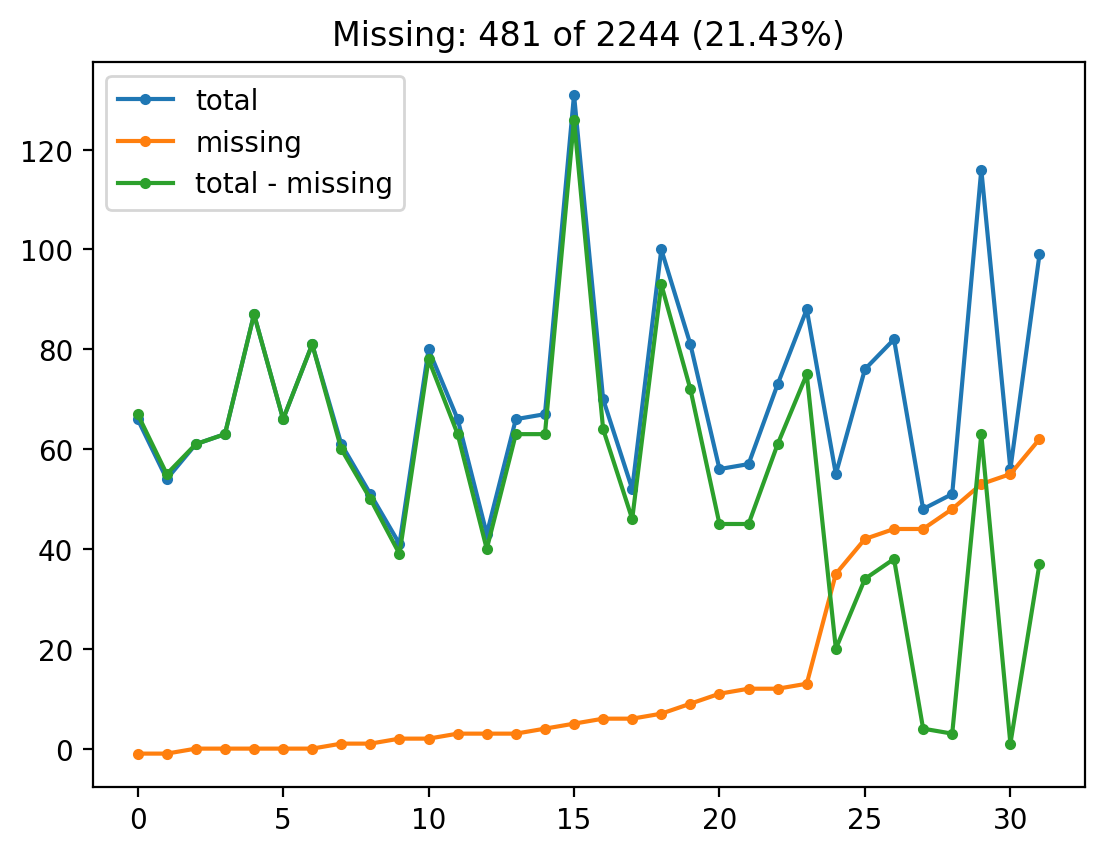

In [258]:
plt.figure(figsize=(6.4, 4.8), dpi=200)
for y in [_.total, _.missing, _.total - _.missing]:
    plt.plot(range(_.shape[0]), y, marker='.')
plt.legend(['total', 'missing', 'total - missing']);
plt.title(
    f'Missing: {_.missing.sum()} of {_.total.sum()}'
    f' ({(_.missing.sum()/_.total.sum())*100:.2f}%)',
    loc='center');
plt.show()

## Extrair concessões de aposentadoria

In [184]:
retire = {}
for i in glob.glob('data/*.txt'):
#     print('file:', i)
    try:
        num = str(int(re.search('\d+', i).group()))
        data = re.search(r'\d{2}-\d{2}-\d{4}', i).group()
    except:
        continue
    _ = Retirements(i, 'regex')
    _.data_frame.rename(str.lower, axis=1, inplace=True)
    _.data_frame['text'] = _.acts_str
    retire[(data, num)] = _.data_frame
#     apos2 = RetAposentadoria(i, 'regex')
#     apos2.data_frame.rename(str.lower, axis=1, inplace=True)
#     break

In [186]:
retire[('20-05-2019', '93')].head(1)

,tipo do ato,sei,nome,matrícula,tipo de aposentadoria,cargo,classe,padrao,quadro,fundamento legal,orgao,vigencia,matricula siape,text
0,Aposentadoria,00040-00003703/2019-69,nan,43.465-5,nan,Tecnico de\nGestao Educacional/Apoio Administ...,nan,3,Quadro de Pessoal do\nDistrito Federal,nan,\nDistrito Federal,nan,nan,APOSENTAR FRANCISCO DAS CHAGAS FILHO matricula...


In [176]:
true_names = sorted(list(douro[(douro.num == 66) & (douro.data == '06-04-2018')].nome_sigrh))
names = sorted(apos1.data_frame.nome.map(lambda x: x.replace('\n', ' ')))
print(len(true_names), ' true names')
print(len(names), ' names')

print("TRUE\t\t\t\t\t\tCAND")
for idx, tp in enumerate(zip(true_names, names)):
    print(idx, end=' ')
    print(*tp, sep=' |********| ')

51  true names
51  names
TRUE						CAND
0 ALCIZIO HENRIQUE LEE LIMA DOS SANTOS |********| ALCIZIO HENRIQUE LEE LIMA DOS SANTOS
1 ALENCAR FERNANDES ALVES |********| ALENCAR FERNANDES ALVES
2 ANA CRISTINA FERREIRA DO NASCIMENTO |********| ANA CRISTINA FERREIRA DO NASCIMENTO
3 ANASTACIO NERES PORTELA |********| ANASTACIO NERES PORTELA
4 ANDREIA CRISTINA CRUZ |********| ANDREIA CRISTINA CRUZ
5 ANTONIETA BARROS DE A DIAS |********| ANTONIETA BARROS DE ARAUJO DIAS
6 BENEDITA MARTINS DA SILVA |********| BENEDITA MARTINS DA SILVA
7 CELIA DA SILVA CORREA LOPES |********| CELIA DA SILVA CORREA LOPES
8 CLAUDIA G P L DAS CHAGAS |********| CLAUDIA GONCALVES PORTELA LISBOA DAS CHAGAS
9 CLEONICE MARIA PINTO MAGALHAES |********| CLEONICE MARIA PINTO MAGALHAES
10 CONCEICAO ROSEMIR DE PAULA PINTO |********| EDINA CHAVES ARAUJO
11 EDINA CHAVES ARAUJO |********| FERNANDA CRISTINA PARENTE ROSAL
12 FERNANDA CRISTINA PARENTE ROSAL |********| HERMINIA MARQUES DE SOUSA
13 HERMINIA MARQUES DE SOUSA |********| J

In [177]:
names[8]

'CLAUDIA GONCALVES PORTELA LISBOA DAS CHAGAS'

In [152]:
true_names

['ADINA VIEIRA MOUHAMAD ABOU',
 'ALCIZIO HENRIQUE LEE LIMA DOS SANTOS',
 'ALENCAR FERNANDES ALVES',
 'ANA CRISTINA FERREIRA DO NASCIMENTO',
 'ANASTACIO NERES PORTELA',
 'ANDREIA CRISTINA CRUZ',
 'ANTONIETA BARROS DE A DIAS',
 'AURIO SOLON DE OLIVEIRA SOUZA',
 'BENEDITA MARTINS DA SILVA',
 'CAROLINE MARIA SOARES RIBEIRO ALCANTARA',
 'CELIA DA SILVA CORREA LOPES',
 'CLAUDIA BARBOSA CARRILHO PEREIRA',
 'CLAUDIA G P L DAS CHAGAS',
 'CLAUDIO SEVERIANO RAMOS',
 'CLEONICE MARIA PINTO MAGALHAES',
 'CONCEICAO ROSEMIR DE PAULA PINTO',
 'EDILMAENI DE JESUS CONCEICAO SILVA',
 'EDINA CHAVES ARAUJO',
 'FERNANDA CRISTINA PARENTE ROSAL',
 'FRANCISCO PORFIRIO DA SILVA',
 'HERMINIA MARQUES DE SOUSA',
 'IVONE FERNANDES GUIMARAES',
 'JADIR DA SILVA BOTELHO',
 'JANETE APARECIDA ROQUE DE ALMEIDA',
 'JAQUELINE SOUZA ALMEIDA',
 'JOAO BATISTA GONCALVES',
 'JOSE MARCILIO LEITE DOS PRAZERES',
 'JOSE RAUL DE OLIVEIRA VIEIRA',
 'JOSE ROMUALDO FERREIRA DA CRUS',
 'JOSE VALDINO DE ALMEIDA',
 'JULIA SANTOS DO NASCIME